> ### Transfer Learning

In [1]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy
from collections import OrderedDict

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

#Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [4]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image_dataset_from_directory

#### Data
Can either download **cats and dogs dataset** from Google to local directory, unzip and use [ImageDataGenerator](#imagegenerator), or use [image_dataset_from_directory](#imagedataset) to generate numpy dataset ready to use.

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    fname='cats_and_dogs.zip', #renamed dataset 
    origin='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', 
    extract=True) #unzip
path_to_zip

In [13]:
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

In [16]:
train_cat_names = os.listdir(os.path.join(train_dir, 'cats'))
train_dog_names = os.listdir(os.path.join(train_dir, 'dogs'))
validation_cat_names = os.listdir(os.path.join(validation_dir, 'cats'))
validation_dog_names = os.listdir(os.path.join(validation_dir, 'dogs'))
print(f'Training set: {len(train_cat_names)} for cats, {len(train_dog_names)} for dogs')
print(f'Validation set: {len(validation_cat_names)} for cats, {len(validation_dog_names)} for dogs')

Training set: 1000 for cats, 1000 for dogs
Validation set: 500 for cats, 500 for dogs


#### Preprocessing
<a id=imagedataset></a>
**image_dataset_from_directory** can read pictures from local path, and automatically label them according to the subdirectories name. Different with **ImageDataGenerator** as a directory iterator, it generates a batch dataset. 

In [87]:
train_dataset = image_dataset_from_directory(
         train_dir, #或者path，然后下面参数加一个subset='train'
         image_size=(150, 150),
         batch_size=32,
         shuffle=True) #随机打乱

validation_dataset = image_dataset_from_directory(
         validation_dir,
         image_size=(150, 150),
         batch_size=32,
         shuffle=True)

classes = train_dataset.class_names #class列表
print(f'Found {len(classes)} classes: {", ".join(classes)}.')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2 classes: cats, dogs.


In [90]:
image_batch, label_batch = next(iter(train_dataset))
image_batch.shape
label_batch.shape

TensorShape([32, 160, 160, 3])

TensorShape([32])

<Figure size 576x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'cats')

(-0.5, 159.5, 159.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'dogs')

(-0.5, 159.5, 159.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'cats')

(-0.5, 159.5, 159.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'cats')

(-0.5, 159.5, 159.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'cats')

(-0.5, 159.5, 159.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'cats')

(-0.5, 159.5, 159.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'cats')

(-0.5, 159.5, 159.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'dogs')

(-0.5, 159.5, 159.5, -0.5)

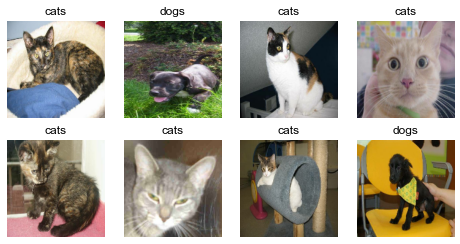

In [69]:
plt.figure(figsize=(8,4))
for images, labels in train_dataset.take(1): #按顺序返回1个batch共32张图，循环1次
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8')) #把tensor转为numpy
        plt.title(classes[labels[i]])
        plt.axis('off')

Generate test set from 20% validation set in batches.

In [88]:
val_batches = tf.data.experimental.cardinality(validation_dataset) #1000/32 = 32 batches
test_dataset = validation_dataset.take(val_batches // 5) #取20%，即6个batches为test set
validation_dataset = validation_dataset.skip(val_batches // 5) #valid set取剩余的batches
print(f'Validation set: {tf.data.experimental.cardinality(validation_dataset)} batches') 
print(f'Test set: {tf.data.experimental.cardinality(test_dataset)} batches')

Validation set: 26 batches
Test set: 6 batches


#### Model
Most classic CNN architectures have pretrained versions on ImageNet's 1.4 million images in 1000 different classes. 

<img src='images/transfer_learning_training.jpg' style='width:400px;height:200px'></img>

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape = (150, 150, 3), 
                        include_top = False, # 包含最后几层FC layers
                        weights = 'imagenet') # None时weights随机初始化，可以直接选imagenet加载预训练的weights

inception.summary()

87916544/87910968 [==============================] - 24s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_____________________

Choose the last layer you want to use from pretrained model, and build your own layers afterwards.

In [16]:
# Pick from pretrained model
for layer in inception.layers:
    layer.trainable = False # freeze pretrained weights，如果全部层都一样，可以直接inception.trainable=False
    
last_layer = inception.get_layer('mixed7')
last_output = last_layer.output
print(f'Last layer output shape: {last_layer.output_shape}')

Last layer output shape: (None, 7, 7, 768)


In [ ]:
# Build our own model
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x) # Reduce overfitting   
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)           
model = keras.Model(inputs=inception.input, outputs=x) 
model.summary()

In [ ]:
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

history = model.fit(
          train_generator, steps_per_epoch = 100, epochs = 20,
          validation_data = validation_generator, validation_steps = 50)

#### Evaluation

In [ ]:
def plot_metrics(history, string):
    plt.plot(history.history[string],label=string)
    plt.plot(history.history['val_'+string],label='val_'+string)
    plt.xlabel("Epochs")
    plt.title(string.capitalize())
    plt.legend()

In [ ]:
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')